In this notebook, we present an algorithm that maps 2D data to 1D and show that 1D CNNs comparable with 2D CNNs. In particular, we read image pixels with Hilbert and modified Sierpinski space-filling curves, and then apply one-dimensional convolutional neural networks. 

We know that space-filling curves preserve a maximum of spatial locality information between elements. We believe that using space-filling curve mapping as a preprocessing tool, preserves enough information of neighbouring pixels to be used by 1D CNNs. We evaluated the classification performance of 1D CNNs on Cifar-10 image dataset. This mapping technique can potentially reduce CNN training cost while perform comparably to 2D CNNs in terms of accuracy.  


In [8]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.python.framework import ops

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


from space_filling_curves import rix, hilbert_curve, scan_image_with_hilbert, modified_sierpinski_curve, scan_image_with_sierpinski

The CIFAR-10 dataset consists of 60000 32x32x3 color images in 10 equal classes. There are 50000 training images and 10000 test images. Each class of images corresponds to a physical object such as airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. 

(40000, 32, 32, 3)
(40000, 1)
(10000, 32, 32, 3)
(10000, 1)
It is a automobile!


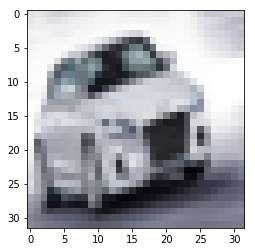

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
num_classes = 10
cifar10_classes = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 
                      5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



def draw_cifar_image(i):
    img = x_train[i]
    label = y_train[i]    
    plt.imshow(img)

    
print("It is a " + str(cifar10_classes[int(y_train[13])]) + "!")
draw_cifar_image(13)    


We can read the image pixels with Hilbert space-filling curve or modified Sierpinski space-filling curve. The main difference between these two curves is that modified Sierpinski curve is more symmetrical and closed.

Here, for example, we read the red matrix of the 4x4x3 image with Hilbert curve in the following order: 35, 19, 22, 13, 4, 0, 8, 3, 7, 1, 3, 10, 53, 16, 25, 6. We read the red matrix of the 4x4x3 image with modified Sierpinski curve in the following order: 35, 19, 22, 25, 6, 53, 16, 10, 3, 1, 7, 8, 0, 4, 3, 13. The code in Python 3 (see space_filling_curves.py) shows how to build the modified Nth order Sierpinski curve and Nth order Hilbert curve.


2nd-order Hilbert curve | 2nd-order modified Sierpiński curve
:-------------------------:|:-------------------------:
<img src="images/hilbertRGB.png" style="width:400px;height:300px"/>  |  <img src="images/readwithcurve.png" style="width:400px;height:300px"/>



Although it is possible to use lower order of the curves to read images, it is not recommended for small images. Here we preserve every pixel in image. 

In [11]:
num_px = x_train.shape[1]
N = math.log10(num_px) / math.log10(2)
N = int(N) # to cover all pixels
print("The order of the curve is " + str(N)) 
#x,y = modified_sierpinski_curve(N)
x,y = hilbert_curve(N)

# normalize data
X_train_orig = x_train/255.
X_val_orig = x_val/255.
X_test_orig = x_test/255.
mtrain = X_train_orig.shape[0]
mval = X_val_orig.shape[0]
mtest = X_test_orig.shape[0]

# convert to one-hot presentation
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_val = keras.utils.to_categorical(y_val, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

# print shapes
print(X_train_orig.shape)
print(X_val_orig.shape)
print(X_test_orig.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

The order of the curve is 5
(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 10)
(10000, 10)
(10000, 10)


We create arrays of zeros and read pixels with Hilbert curve for Red, Green, and Blue channels. The data therefore transformed from (number of examples, number of pixels, number of pixels, 3) to (number of examples, $2^{2N}$, 3), where $N$ is the order of the curve.

In [5]:
train_data = np.zeros([X_train_orig.shape[0], 2**(2*N), X_train_orig.shape[3]])
val_data = np.zeros([X_test_orig.shape[0], 2**(2*N), X_val_orig.shape[3]])
test_data = np.zeros([X_test_orig.shape[0], 2**(2*N), X_test_orig.shape[3]])

train_data[:, :, 0] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 0], x, y)        
val_data[:, :, 0] = scan_image_with_hilbert(N, mval, X_val_orig[:, :, :, 0], x, y) 
test_data[:, :, 0] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 0], x, y) 

train_data[:, :, 1] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 1], x, y)  
val_data[:, :, 1] = scan_image_with_hilbert(N, mval, X_val_orig[:, :, :, 1], x, y) 
test_data[:, :, 1] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 1], x, y) 

train_data[:, :, 2] = scan_image_with_hilbert(N, mtrain, X_train_orig[:, :, :, 2], x, y)    
val_data[:, :, 2] = scan_image_with_hilbert(N, mval, X_val_orig[:, :, :, 2], x, y) 
test_data[:, :, 2] = scan_image_with_hilbert(N, mtest, X_test_orig[:, :, :, 2], x, y) 

# new shapes
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(40000, 1024, 3)
(10000, 1024, 3)
(10000, 1024, 3)


We define the model as a Sequential model in Keras. We define the model as having two blocks of two 1D CNN layers followed by  a pooling layer, then a dropout layer for regularization. After that, the learned features are flattened to a vector and pass through a fully connected layer. Then the output layer used to make predictions. We use batch normalization and ELU activation function elsewhere. Adam optimizer with default learning rate of 0.001 was used. We trained this model for 10 epochs using batches of 16 examples and achieved 92.25% train accuracy, 69.45% validation accuracy, and 68.45% test accuracy. It took 3334 seconds to run. 

More details about the model hyperparameters are below:

In the first block we use
- 1D convolutional layers with 64 filters (feature detectors), each of length 4 (kernel size or sliding window). In this initial layer, 64 sliding windows of size 4 will run through the data to learn basic features. This allows us to train 64 different features on the first layer of the network.
- The exponential linear unit (ELU) activation function has a nonzero gradient for $z < 0$. It was used to avoid the dying units issue (some neurons die and output 0) when using RELU.
- To zero-center and normalize the inputs, we use the batch normalization techique that evaluates mean and standard deviation  of the inputs over the current mini-batch. This technique makes the networks much less sensitive to the weight initialization.
- MaxPooling of size 2 and stride 1 was applied by taking the max value of every 2 features. This means that the size of the output matrix of this layer is only a half of the input matrix.
- Dropout layer with rate 0.25 was used to ensure that at every trainig step, every input neuron has the probability 0.25 of being temporarily dropped (ignored). This means that the network becomes less sensitive to react to smaller variations in the data, and likely will increase test accuracy.

The second block is similar to the first one, except 128 filters were used and AveragePooling was used instead of MaxPooling. After that we 'flatten' and turn the output into a vector. The first fully connected layer defined as Dense(128) takes the input from the features analysis and applies weights to predict the correct label. The last output layer defined by Dense(num_classes) uses a softmax activation function to give probabilities for the num_classes=10 output classes.


We train our model for 10 epochs, meaning that we completely pass through the training dataset 10 times. After evey 16 training examples (batch_size=16) the model's internal parameters were updated. One can use larger batch size like 32 or 64 which will lead to faster updates but may take more time to converge.

In [7]:
start_time = time.time()

# Create the model
model = Sequential()

model.add(Conv1D(64, 4, input_shape=train_data.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.25))

model.add(Conv1D(128, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 16
opt = keras.optimizers.Adam() #keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

checkpoint = ModelCheckpoint(filepath="hilbert_weights.hdf5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

model.fit(train_data, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[checkpoint],
          verbose=0,
          validation_data=(val_data, Y_val))

model.load_weights('hilbert_weights.hdf5')
score_train = model.evaluate(train_data, Y_train, verbose=0)
score_val = model.evaluate(val_data, Y_val, verbose=0)
score_test = model.evaluate(test_data, Y_test, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
print("--- %s seconds ---" % (time.time() - start_time))


Train loss: 0.2876819651544094
Train accuracy: 0.92245
Val loss: 0.8860030125617981
Val accuracy: 0.6945
Test loss: 0.9182343528747559
Test accuracy: 0.6845
--- 3333.5106382369995 seconds ---


Previously we read pixels with Hilbert curve. Here we read pixels with modified Sierpinski curve and use the same model as above to train 1D CNNs. After 10 epochs the model achieved 91.35% train accuracy, 70.36% test accuracy, and 69.87% validation accuracy in 3334 seconds. 

In [17]:
# read with modified Sierpinski curve

x,y = modified_sierpinski_curve(N)

train_data = np.zeros([X_train_orig.shape[0], 2**(2*N), X_train_orig.shape[3]])
val_data = np.zeros([X_test_orig.shape[0], 2**(2*N), X_val_orig.shape[3]])
test_data = np.zeros([X_test_orig.shape[0], 2**(2*N), X_test_orig.shape[3]])

train_data[:, :, 0] = scan_image_with_sierpinski(N, mtrain, X_train_orig[:, :, :, 0], x, y)        
val_data[:, :, 0] = scan_image_with_sierpinski(N, mval, X_val_orig[:, :, :, 0], x, y) 
test_data[:, :, 0] = scan_image_with_sierpinski(N, mtest, X_test_orig[:, :, :, 0], x, y) 

train_data[:, :, 1] = scan_image_with_sierpinski(N, mtrain, X_train_orig[:, :, :, 1], x, y)  
val_data[:, :, 1] = scan_image_with_sierpinski(N, mval, X_val_orig[:, :, :, 1], x, y) 
test_data[:, :, 1] = scan_image_with_sierpinski(N, mtest, X_test_orig[:, :, :, 1], x, y) 

train_data[:, :, 2] = scan_image_with_sierpinski(N, mtrain, X_train_orig[:, :, :, 2], x, y)    
val_data[:, :, 2] = scan_image_with_sierpinski(N, mval, X_val_orig[:, :, :, 2], x, y) 
test_data[:, :, 2] = scan_image_with_sierpinski(N, mtest, X_test_orig[:, :, :, 2], x, y) 


# train 1D CNNs
start_time = time.time()

# Create the model
model = Sequential()

model.add(Conv1D(64, 4, input_shape=train_data.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(64, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.25))

model.add(Conv1D(128, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 4))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 16

opt = keras.optimizers.Adam() #keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

checkpoint = ModelCheckpoint(filepath="sierpinski_weights.hdf5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

model.fit(train_data, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[checkpoint],
          verbose=0,
          validation_data=(val_data, Y_val))

model.load_weights('sierpinski_weights.hdf5')
score_train = model.evaluate(train_data, Y_train, verbose=0)
score_val = model.evaluate(val_data, Y_val, verbose=0)
score_test = model.evaluate(test_data, Y_test, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
print("--- %s seconds ---" % (time.time() - start_time))

Train loss: 0.29816328558325766
Train accuracy: 0.913475
Val loss: 0.8763399494171142
Val accuracy: 0.7036
Test loss: 0.8978019725322723
Test accuracy: 0.6987
--- 3334.4803388118744 seconds ---


Here we apply various 2D CNNs to the original data. We use similar architecture as for 1D CNNs. The model achieves 89-92% train accuracy, 78-81% validation accuracy, and 78-80% test accuracy in around 2400 seconds. 

In [13]:
start_time = time.time()

# Create the model
model = Sequential()
model.add(Conv2D(64, (4,4), input_shape=X_train_orig.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(128, (4,4)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 16

opt = keras.optimizers.Adam() #keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

checkpoint = ModelCheckpoint(filepath="cnn2d_weights.hdf5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train_orig, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[checkpoint],
          verbose=0,
          validation_data=(X_val_orig, Y_val))

model.load_weights('cnn2d_weights.hdf5')
score_train = model.evaluate(X_train_orig, Y_train, verbose=0)
score_val = model.evaluate(X_val_orig, Y_val, verbose=0)
score_test = model.evaluate(X_test_orig, Y_test, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
print("--- %s seconds ---" % (time.time() - start_time))



Train loss: 0.3256031199216843
Train accuracy: 0.8938
Val loss: 0.6478643950462342
Val accuracy: 0.7829
Test loss: 0.6506906617164612
Test accuracy: 0.7812
--- 2664.7220237255096 seconds ---


In [14]:
start_time = time.time()

# Create the model 2824
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=X_train_orig.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(128, (3,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 16

opt = keras.optimizers.Adam() #keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

checkpoint = ModelCheckpoint(filepath="cnn2d_elu_weights.hdf5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train_orig, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[checkpoint],
          verbose=0,
          validation_data=(X_val_orig, Y_val))

model.load_weights('cnn2d_elu_weights.hdf5')
score_train = model.evaluate(X_train_orig, Y_train, verbose=0)
score_val = model.evaluate(X_val_orig, Y_val, verbose=0)
score_test = model.evaluate(X_test_orig, Y_test, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
print("--- %s seconds ---" % (time.time() - start_time))



Train loss: 0.22277186031341553
Train accuracy: 0.92985
Val loss: 0.5760130873203277
Val accuracy: 0.8129
Test loss: 0.58989321641922
Test accuracy: 0.8029
--- 2414.280870437622 seconds ---


In [15]:
start_time = time.time()

# Create the model 2824
model = Sequential()
model.add(Conv2D(64, (2,2), input_shape=X_train_orig.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (2,2)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(128, (2,2)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (2,2)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(128, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

epochs = 10
batch_size = 16

opt = keras.optimizers.Adam() #keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

checkpoint = ModelCheckpoint(filepath="cnn2d_elu_weights.hdf5", verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

model.fit(X_train_orig, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[checkpoint],
          verbose=0,
          validation_data=(X_val_orig, Y_val))

model.load_weights('cnn2d_elu_weights.hdf5')
score_train = model.evaluate(X_train_orig, Y_train, verbose=0)
score_val = model.evaluate(X_val_orig, Y_val, verbose=0)
score_test = model.evaluate(X_test_orig, Y_test, verbose=0)
print('Train loss:', score_train[0])
print('Train accuracy:', score_train[1])
print('Val loss:', score_val[0])
print('Val accuracy:', score_val[1])
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
print("--- %s seconds ---" % (time.time() - start_time))



Train loss: 0.2805523369759321
Train accuracy: 0.9077
Val loss: 0.6048455331325531
Val accuracy: 0.7941
Test loss: 0.6162231415271759
Test accuracy: 0.7904
--- 2217.8593513965607 seconds ---
